In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

## Load and Explore Data

In [2]:
pd.set_option('display.max_columns', None)  

df = pd.read_csv('data/dataset.csv')
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


There are too many generes in our dataset, we're only interested in the most popular generes, so we looked for the top 20 genres with the highest average popularity 

In [3]:
music_features = df[['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'track_genre']]
mean_features = music_features.groupby('track_genre').mean()

# sort by popularity and display results
for genre in mean_features.sort_values('popularity', ascending=False).index[0:20]: #ascending=False for most popular
    print(genre)
df = df[(df['track_genre'].isin(mean_features.sort_values('popularity', ascending=True).index[0:10])) | (df['track_genre'].isin(mean_features.sort_values('popularity', ascending=False).index[0:10]))]


pop-film
k-pop
chill
sad
grunge
indian
anime
emo
sertanejo
pop
progressive-house
piano
mandopop
deep-house
brazil
electronic
pagode
ambient
british
metal


Feature Selection

In [4]:
first_row = df.iloc[0]

# Iterating over each item in the row
for column_name, value in first_row.items():
    print(f"{column_name}: {value}")

Unnamed: 0: 5000
track_id: 1gUAX2ImxDsB3YDcyxMXlB
artists: 美波
album_name: カワキヲアメク
track_name: カワキヲアメク
popularity: 71
duration_ms: 251933
explicit: False
danceability: 0.541
energy: 0.846
key: 6
loudness: -2.729
mode: 0
speechiness: 0.0551
acousticness: 0.0122
instrumentalness: 0.000149
liveness: 0.163
valence: 0.524
tempo: 129.138
time_signature: 4
track_genre: anime


I want to keep these features:

- popularity, scale it
- duration_ms, scale it
- explicit, but transform into numeric
- danceability, scale it
- energy, scale it
- key, one hot encode
- loudness, scale it
- mode, one hot encode
- speechiness, scale it
- acousticness, scale it
- intrumentalness: scale it
- liveness: scale it
- tempo: scale it
- time_signature: scale it

In [5]:
df['mode'].value_counts()


mode
1    12022
0     7978
Name: count, dtype: int64

In [27]:
df2 = df.copy()
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming df is your original DataFrame

# Define columns to scale (excluding 'explicit', 'key', and 'mode' for now)
scale_columns = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 
                 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo']

# Define the scaler
scaler = StandardScaler()

# Apply scaling on the selected columns
df2[scale_columns] = scaler.fit_transform(df2[scale_columns])
df2.head()

# One-hot encode 'key' and 'mode'
df2 = pd.get_dummies(df2, columns=['key', 'mode', 'explicit', 'time_signature'], drop_first=True)
df2 = df2.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'], axis=1)


,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,explicit_True,time_signature_1,time_signature_3,time_signature_4,time_signature_5
5000,1.553581,0.154339,-0.155131,0.965949,1.198341,-0.359047,-0.996376,-0.617291,-0.193627,0.524,0.318944,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
5001,1.631544,0.068565,-0.694712,1.301083,1.206308,-0.409629,-1.030566,-0.228825,0.735425,0.384,-0.958313,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
5002,2.021358,-0.270445,0.029868,1.327742,0.756394,0.214592,-1.024789,-0.617696,-0.628165,0.292,-0.604207,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
5003,1.631544,0.055677,-0.324714,1.129708,1.193634,-0.001529,-0.891753,-0.617705,-0.573480,0.332,0.518247,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
5004,1.124786,0.123903,0.615698,0.687941,0.742997,-0.424573,-0.981790,-0.616452,-0.464111,0.502,0.285840,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [7]:
df2.head()

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,explicit_True,time_signature_1,time_signature_3,time_signature_4,time_signature_5
5000,0.71,0.053259,0.549797,0.846844,0.868306,0.057576,0.012249,0.000149,0.154457,0.524,0.586887,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
5001,0.73,0.050765,0.443089,0.934934,0.869291,0.052978,0.000010,0.140140,0.315222,0.384,0.415749,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
5002,0.83,0.040905,0.586382,0.941941,0.813682,0.109718,0.002078,0.000003,0.079263,0.292,0.463195,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
5003,0.73,0.050390,0.516260,0.889888,0.867724,0.090073,0.049699,0.000000,0.088726,0.332,0.613591,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
5004,0.60,0.052374,0.702236,0.773769,0.812026,0.051620,0.017470,0.000451,0.107652,0.502,0.582451,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [8]:
df = df2

Look at the distribution of our data

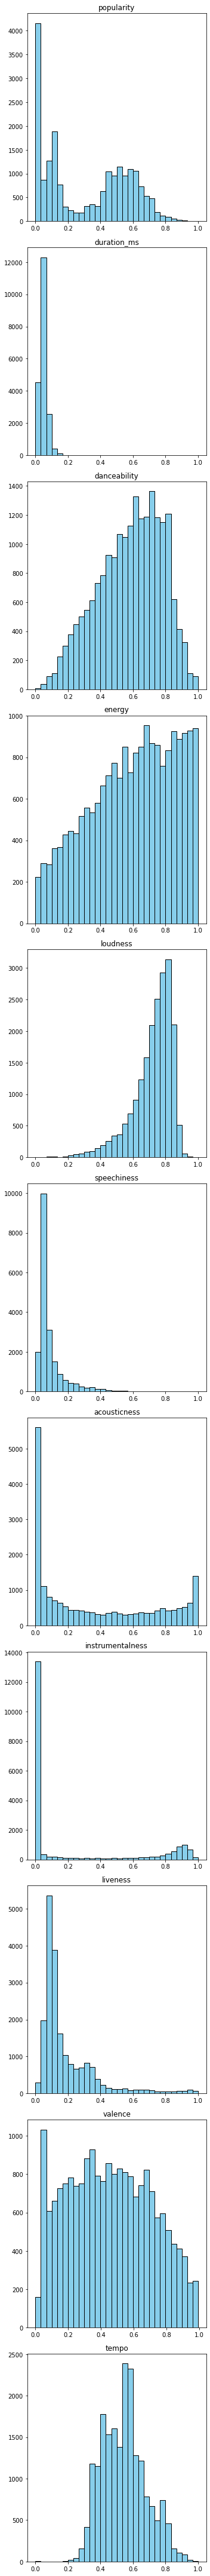

In [9]:
import matplotlib.pyplot as plt
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Plotting histograms for each numeric column
fig, ax = plt.subplots(len(df_numeric.columns), 1, figsize=(5, 60))

for i, column in enumerate(df_numeric.columns):
    ax[i].hist(df_numeric[column], bins=30, color='skyblue', edgecolor='black')
    ax[i].set_title(column)

plt.tight_layout()
plt.show()

# Dimensional Reduction (UMAP)

/home/gryang/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


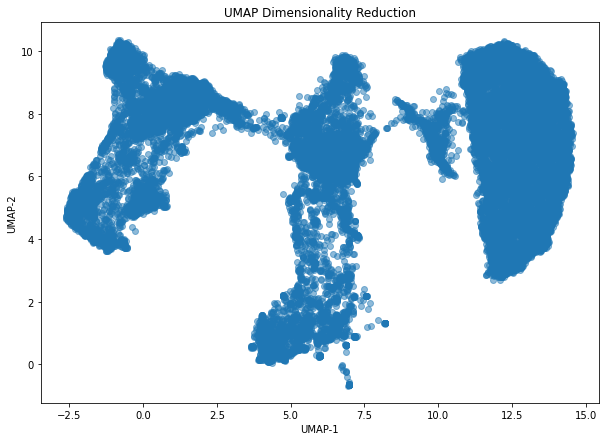

In [28]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Selecting only numeric columns (assuming your DataFrame is named as 'df')
numeric_columns = df.select_dtypes(include=[np.number]).columns
data_for_umap = df[numeric_columns]

# Initialize UMAP. You can adjust n_neighbors and min_dist based on your data characteristics
umap_model = umap.UMAP(random_state = 99, min_dist = 0.1, n_neighbors = 100)

# Fit the model and transform your data to 2 dimensions
umap_data = umap_model.fit_transform(data_for_umap)

# Plotting the results
plt.figure(figsize=(10, 7))
plt.scatter(umap_data[:, 0], umap_data[:, 1], alpha=0.5)
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

In [12]:
umap_data.shape

(20000, 2)

## Dimensionality Reduction (PCA)

In [29]:
# PCA for dimensionality reduction

pca = PCA(n_components=2) # Adjust n_components based on your dataset, .95 leads to 53 features
pca_data = pca.fit_transform(df)
pca_data.shape

(20000, 2)

In [14]:
umap_data

array([[12.565955,  9.187331],
       [11.752246,  9.269431],
       [11.79544 ,  9.007429],
       ...,
       [14.27286 ,  7.440406],
       [14.356278,  7.657329],
       [14.279971,  8.151843]], dtype=float32)

In [15]:
pca_data

array([[-0.71717168,  0.38399902],
       [-0.23869437, -0.58148475],
       [-0.35386518, -0.61712512],
       ...,
       [-0.62815718,  0.29915879],
       [-0.2649787 , -0.60142807],
       [-0.36775964, -0.4786137 ]])

## Clustering (Spectral)


In [19]:
inertia = []
K = range(1, 10)  # Adjust the range of k as needed

for k in K:
    spectral = SpectralClustering(n_clusters=k, random_state=42)
    spectral.fit(umap_data)
    inertia.append(spectral.inertia_)
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k for umap')
plt.show()


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5d8a7528b0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5cdfbb69d0>
Traceback 

AttributeError: 'SpectralClustering' object has no attribute 'inertia_'

In [ ]:
inertia = []
K = range(1, 10)  # Adjust the range of k as needed

for k in K:
    spectral = SpectralClustering(n_clusters=k, random_state=42)
    spectral.fit(umap_data)
    inertia.append(spectral.inertia_)
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k for pca')
plt.show()

In [20]:
spectral = SpectralClustering(n_clusters=3, random_state=42) # Adjust n_clusters based on your needs
clusters = spectral.fit_predict(umap_data)

#Evaluate silhouette score
#silhouette_avg = silhouette_score(umap_data, clusters_umap)

#print(f'Silhouette Score: {silhouette_avg:.2f}')

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5ce41f2b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5cdf80af70>
Traceback 

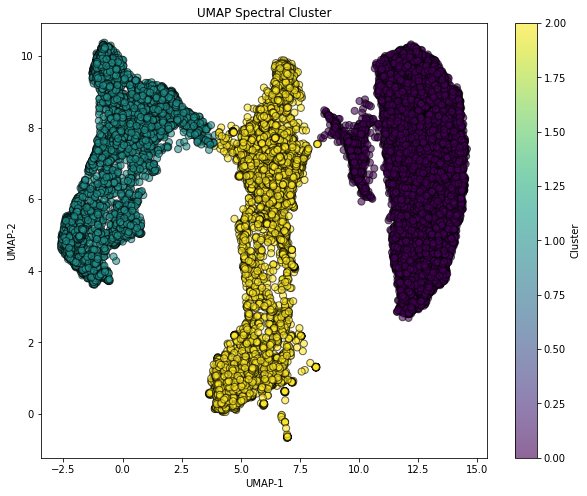

In [22]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(umap_data[:, 0], umap_data[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title('UMAP Spectral Cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.colorbar(label='Cluster')
plt.show()

In [24]:
spectral = SpectralClustering(n_clusters=2, random_state=42) # Adjust n_clusters based on your needs
pca_clusters = spectral.fit_predict(pca_data)

#Evaluate silhouette score
# silhouette_avg = silhouette_score(pca_data, pca_clusters)

# print(f'Silhouette Score: {silhouette_avg:.2f}')

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5cdfc2e160>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5cdfc2e160>
Traceback 

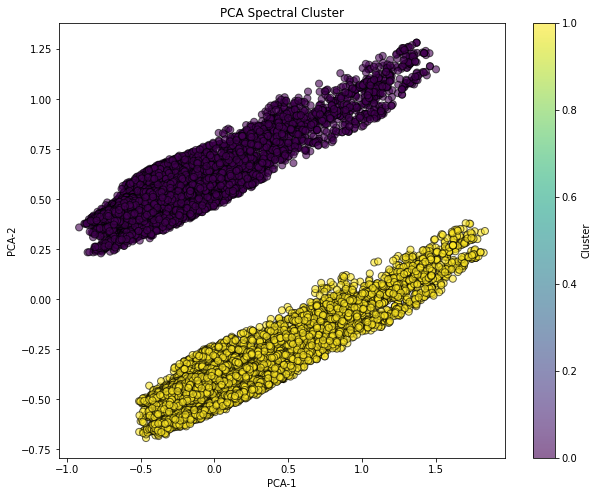

In [25]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=pca_clusters, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title('PCA Spectral Cluster')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.colorbar(label='Cluster')
plt.show()